# Unveiling Bias in Gender Violence Perception on Italian Social Media

## Importing Libraries

In [166]:
%pip install clean-text

Note: you may need to restart the kernel to use updated packages.


In [167]:
# import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import regex as re
import spacy
import nltk
from cleantext import clean
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE


In [168]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cicci\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [169]:
!python -m spacy download it_core_news_sm

     --------------------------------------- 13.0/13.0 MB 13.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')


## Reading and Cleaning Data

### Read Df

This data frame comes from extensive and hard scraping on Nitter, one of the last available resources to scrape Twitter without rate limits and high expenses. However, because of the instability of the various instances, we are not sure the results will be easily replicated if trying to run again the twitter.ipynb script. 

In [170]:
# read the data
df = pd.read_csv('twitter_data_ext.csv')

In [171]:
# drop the first column
# df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,user,username,date,text,comments,retweets,quotes,likes
0,Sciking,@ScikingFS,Apr 19,"Se solo le donne possono parlare di aborto, so...",0,0,0,0
1,💲ℹ️〽️⭕.🇪🇺🇺🇦 #Il Silenzio é Sottovalutato❣️©🤫,@Simo42953017,Apr 19,#femminicidio #femminicidi,0,0,0,0
2,pubblicanow.it,@pubblicanow,Apr 19,Paesi Baschi: aiuto annuale per gli orfani di ...,0,0,0,0
3,Italy in Austria,@ItalyinAustria,Apr 19,L'Ambasciata d'Italia a Vienna aderisce alla c...,0,0,0,0
4,𝙈𝙖𝙧𝙠 𝙋. 𝙇𝙚 𝙃𝙖𝙫𝙧𝙚,@marklehavre,Apr 19,Bhe speriamo che non sia per qualche femminici...,0,0,0,1


In [172]:
# check the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62624 entries, 0 to 62623
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user      62624 non-null  object
 1   username  62624 non-null  object
 2   date      62624 non-null  object
 3   text      62622 non-null  object
 4   comments  62624 non-null  int64 
 5   retweets  62624 non-null  object
 6   quotes    62624 non-null  int64 
 7   likes     62624 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.8+ MB


The dates of 2024 have been saved with just day and month, therefore we need to add the year

In [173]:
# add the year to all the dates of 2024
df['date'] = df['date'].apply(lambda x: x + ' 2024' if len(x) < 10 else x)

In [174]:
# convert the date to datetime
df['date'] = pd.to_datetime(df['date'])

In [175]:
# clean the text column
df['text'] = df['text'].apply(lambda x: str(x).replace('\n', ' '))

In [176]:
# first five rows
df.head()

,user,username,date,text,comments,retweets,quotes,likes
0,Sciking,@ScikingFS,2024-04-19,"Se solo le donne possono parlare di aborto, so...",0,0,0,0
1,💲ℹ️〽️⭕.🇪🇺🇺🇦 #Il Silenzio é Sottovalutato❣️©🤫,@Simo42953017,2024-04-19,#femminicidio #femminicidi,0,0,0,0
2,pubblicanow.it,@pubblicanow,2024-04-19,Paesi Baschi: aiuto annuale per gli orfani di ...,0,0,0,0
3,Italy in Austria,@ItalyinAustria,2024-04-19,L'Ambasciata d'Italia a Vienna aderisce alla c...,0,0,0,0
4,𝙈𝙖𝙧𝙠 𝙋. 𝙇𝙚 𝙃𝙖𝙫𝙧𝙚,@marklehavre,2024-04-19,Bhe speriamo che non sia per qualche femminici...,0,0,0,1


This is the cleaned final data frame!

## Exploratory Data Analysis

### Polarization event

We chose as a polarization event the "Cecchettin case", that greatly moved public opinion regarding the hot topic of violence on women in italy.

In [177]:
# create a variable for the polarizing event
pol_event = dt.datetime(2023, 11, 11)

### Simple Tweet Count

In [178]:
# group the data by date
count_by_date = df.groupby('date').count()
count_by_date['cum_sum'] = count_by_date['user'].cumsum()
count_by_date.head()

,user,username,text,comments,retweets,quotes,likes,cum_sum
date,,,,,,,,
2022-02-16,15,15,15,15,15,15,15,15
2022-02-17,24,24,24,24,24,24,24,39
2022-02-18,19,19,19,19,19,19,19,58
2022-02-19,11,11,11,11,11,11,11,69
2022-02-20,4,4,4,4,4,4,4,73


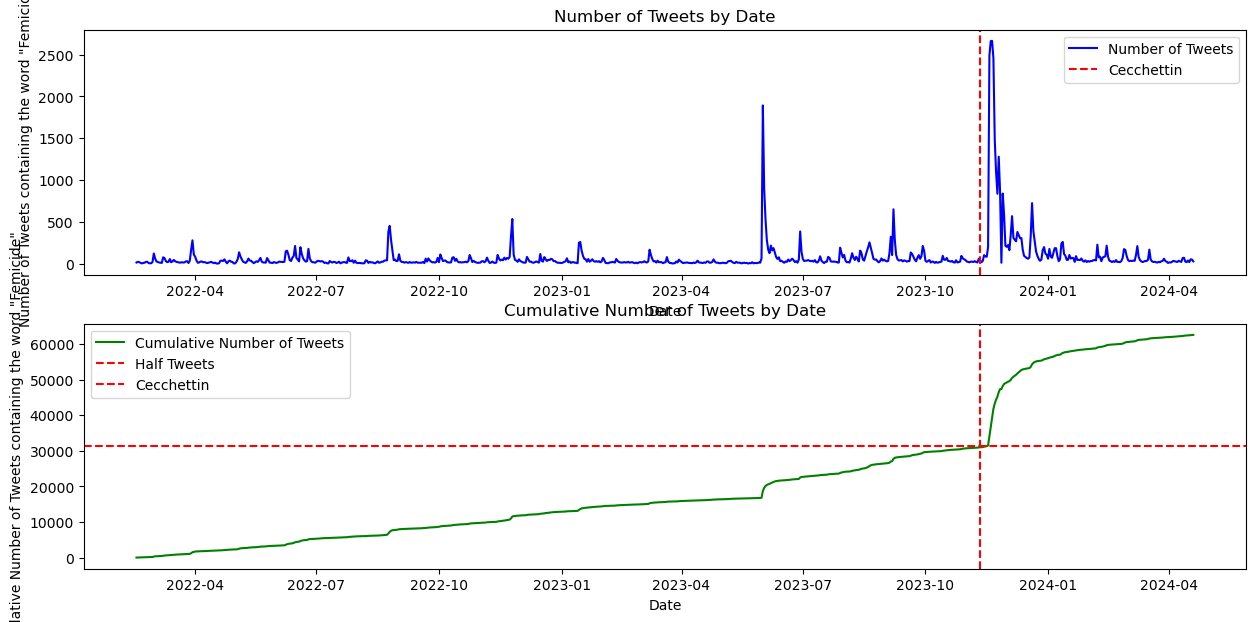

In [179]:
# plot the number of tweets by date
fig, axs = plt.subplots(2, 1, figsize=(15, 7))
ax = axs[0]
ax.plot(count_by_date.index, count_by_date['text'], label='Number of Tweets', color='blue')
ax.axvline(pol_event, color='red', linestyle='--', label='Cecchettin')
ax.set_title('Number of Tweets by Date')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets containing the word "Femicide"')
ax.legend()

ax = axs[1]
ax.plot(count_by_date.index, count_by_date['cum_sum'], label='Cumulative Number of Tweets', color='green')
ax.axhline(count_by_date['cum_sum'].max()/2, color='red', linestyle='--', label='Half Tweets')
ax.axvline(pol_event, color='red', linestyle='--', label='Cecchettin')
ax.set_title('Cumulative Number of Tweets by Date')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Number of Tweets containing the word "Femicide"')
ax.legend()

plt.show()

### Number of Different Users

In [180]:
# count the number of different users
n_different_users = df['user'].nunique()
print(f'There are {n_different_users} different users in the dataset (that contains {len(df)} tweets)')

There are 23743 different users in the dataset (that contains 62624 tweets)


In [181]:
# list of all different users
different_users = df['user'].unique()
different_users

array(['Sciking', '💲ℹ️〽️⭕.🇪🇺🇺🇦 #Il Silenzio é Sottovalutato❣️©🤫',
       'pubblicanow.it', ...,
       '.•.°• 🦦|| young royals & liceali gay era °.•', 'Lucia Guarano',
       'Laura Garavini'], dtype=object)

In [182]:
users_df = df.groupby('user').agg(list).reset_index()
users_df['username'] = users_df['username'].apply(lambda x: x[0])
users_df.head()

,user,username,date,text,comments,retweets,quotes,likes
0,raffaele52,@raffaele521,[2023-11-21 00:00:00],[La sua conoscenza del femminicidio è straordi...,[0],[0],[0],[0]
1,Shana Loricco,@shanaloricco201,[2023-12-05 00:00:00],"[Parole forti, chiare. Giuste.\r #LorenzoGaspa...",[0],[0],[0],[0]
2,"""Lehodettocresci"" E io sono cresciuta🌈🌻",@nagioia08,"[2023-10-04 00:00:00, 2023-06-01 00:00:00, 202...",[D'altronde\r Pi3rsilvio ha cacciato la d'urso...,"[0, 0, 2, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[ 8, 0, 0, 3]"
3,"""seneca&pericle""",@senecaepericle,[2023-01-24 00:00:00],[Non parliamo poi del femminicidio...],[0],[0],[0],[0]
4,# claudia ✧ 🔭,@308bangtan,[2023-08-01 00:00:00],"[in realtà penalmente parlando non è uguale, u...",[0],[0],[0],[0]


In [183]:
users_df['n_tweets'] = users_df['text'].apply(lambda x: len(x))

### Number of Tweets per User

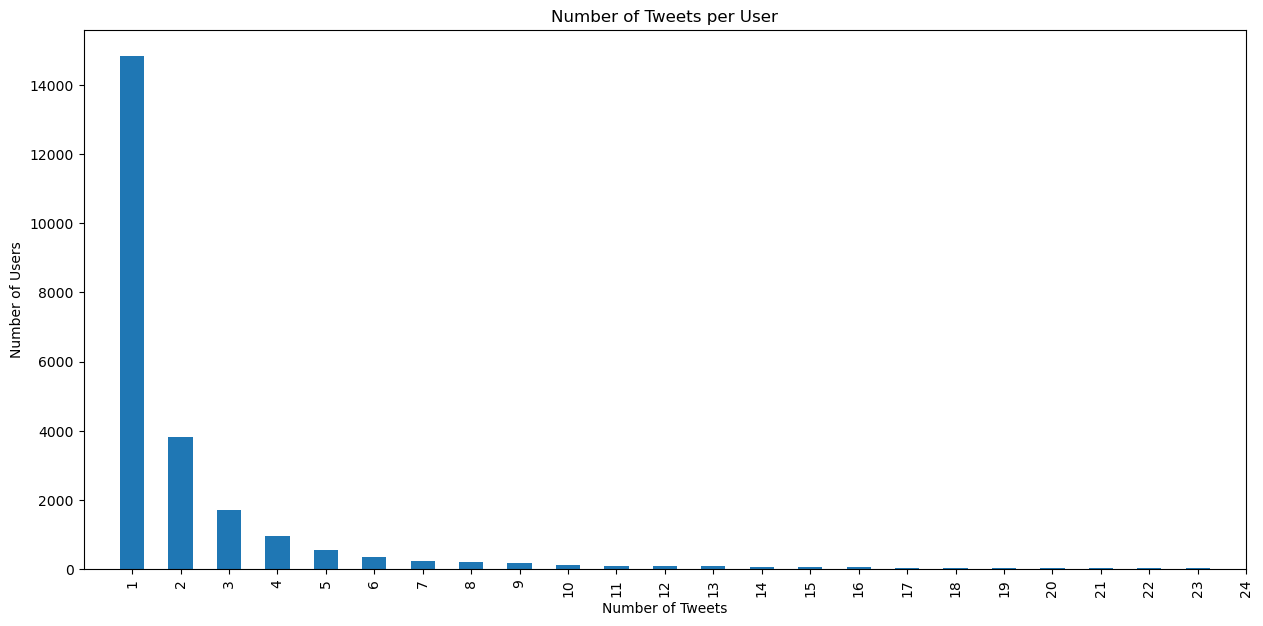

In [184]:
fig, ax = plt.subplots(figsize=(15, 7))
users_df['n_tweets'].value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title('Number of Tweets per User')
ax.set_xlabel('Number of Tweets')
ax.set_ylabel('Number of Users')
ax.set_xlim(-1, 23)

plt.show()

In [185]:
with open('users.csv', 'w') as f:
    users = users_df.sort_values('n_tweets', ascending=False)['username'].values
    for user in users:
        f.write(user + ',' + '\n')

### Label Institutions

In [186]:
usernames = [
    "@repubblica", "@LaStampa", "@Corriere", "@ilmessaggeroit", "@ilgiornale", "@fattoquotidiano",
    "@TV2000it", "@SkyTG24", "@Tg3web", "@MediasetTgcom24", "@tg2rai", "@TgLa7",
    "@Radio1Rai", "@rtl1025", "@RaiNews", "@RadioVoceVicina", "@RADIOBRUNO1", "@RadioCapital_fm",
    "@fanpage", "@globalistIT", "@Agenzia_Ansa", "@LaPresse_news", "@direpuntoit", "@Adnkronos",
    "@VanityFairIt", "@361_magazine", "@InsertoMagazine",
    "@giallolorca", "@genderedform", "@GQ_Italia", "@Internazionale",
    "@fisco24_info", "@bizcommunityit", "@magzinemag",
    "@Noviolenzadonne", "@NonunadimenoF", "@amnestyitalia",
    "@bizcommunityit", "@AgenPolitica", "@Femminicidio",
    "@Movimento5Stelle", "@leganord", "@ForzaItalia", "@DemocraziaAtea"
]

# usernames_2 = 

In [187]:
def is_in_list(x, lis):
    if x in lis:
        return 1
    else:
        return 0

In [188]:
df['is_institution'] = df['username'].apply(lambda x: is_in_list(x, usernames))

<Axes: >

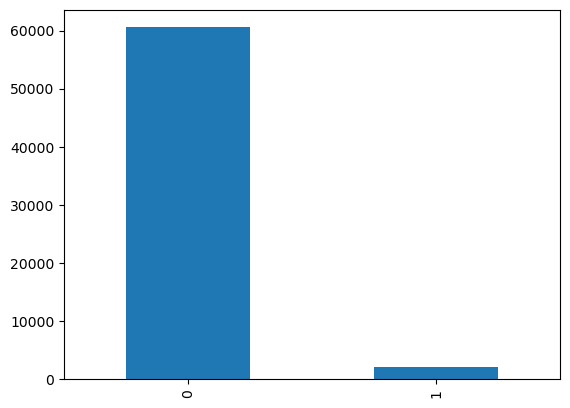

In [189]:
df['is_institution'].value_counts().plot(kind = 'bar')

## Data Processing

### Split Dates

In [190]:
pol_event_date = dt.datetime(2023, 11, 11)
df['after'] = 0
df.loc[df['date'] > pol_event_date, 'after'] = 1

### Create Hashtag Column

In [191]:
# function to get hashtags
def get_hashtags(text):
    hashtags = re.findall(r'#\w+', text)
    if hashtags != []:
        return re.findall(r'#\w+', text)
    else:
        return np.nan

In [192]:
df['hashtags'] = df['text'].apply(get_hashtags)

In [193]:
df.loc[df['hashtags'].notna(), 'hashtags'].reset_index(drop=True)

0                            [#femminicidio, #femminicidi]
1                                               [#Raiplay]
2                                          [#Femminicidio]
3                    [#Attualità, #Italia, #UltimeNotizie]
4                                   [#Sardegna, #violenza]
                               ...                        
22072    [#humanrights, #Imrali, #Turkey, #FreeOcalanNo...
22073            [#humanrights, #Turkey, #Kurds, #podcast]
22074                                     [#FreeOcalanNow]
22075                        [#eutanasialegale, #medioevo]
22076         [#uominimaltrattanti, #femminicidio, #donne]
Name: hashtags, Length: 22077, dtype: object

### Clean Tweets

In [194]:
def remover(text, chars = ['@', '#', 'http']):

    starting_chars = '|'.join(chars)
    for word in text.split():
        if re.match(f'{starting_chars}[A-za-z]+', word):
            text = text.replace(word, '')
        
    return text

In [195]:
def remove_apostrophe(text):
    return text.replace("'", " ")

In [196]:
def remove_words_under(text, n=3):
    return ' '.join([word for word in text.split() if len(word) > n])

In [197]:
def duster(text):
    return remove_words_under(remove_apostrophe(remover(text)))

In [198]:
df['clean_text'] = df['text'].apply(lambda x: duster(x).lower())
df['clean_text'] = df['clean_text'].apply(lambda x: clean(x, no_urls=True, no_emails=True, no_phone_numbers=True, no_numbers=True, no_digits=True, no_currency_symbols=True, no_punct=True, no_emoji=True, replace_with_url='', replace_with_email='', replace_with_phone_number='', replace_with_number='', replace_with_digit='', replace_with_currency_symbol='', replace_with_punct=''))

In [199]:
df['clean_text'].head()

0    solo donne possono parlare aborto solo uomini ...
1                                                     
2    paesi baschi aiuto annuale orfani femminicidio...
3    ambasciata italia vienna aderisce alla campagn...
4    speriamo qualche femminicidio omicidio buon la...
Name: clean_text, dtype: object

In [200]:
#nlp = spacy.load('it_core_news_sm')
from nltk.corpus import stopwords
italian_stopwords = stopwords.words('italian')

In [201]:
texts_before = df.loc[(df['after'] == 0) & (df['is_institution'] == 0), 'clean_text'].values
texts_after = df.loc[(df['after'] == 1) & (df['is_institution'] == 0), 'clean_text'].values
# documents_before = list(nlp.pipe(texts_before))
# documents_after = list(nlp.pipe(texts_after))

In [202]:
texts_after

array(['solo donne possono parlare aborto solo uomini possono parlare femminicidio semplice conseguenza logica',
       '',
       'paesi baschi aiuto annuale orfani femminicidio pubblicanowitpa chiara imbimbo',
       ...,
       'cadavere trovato residence salernitano pista femminicidio salernonotizieit',
       'italia sicuro sarebbe vittima femminicidio',
       'paestum donna napoletana morta residence pista femminicidio ilmattinoit ilmattinoitsalernocapacci'],
      dtype=object)

In [203]:
corpus_before = [[word for word in doc.split() if word not in italian_stopwords] for doc in texts_before]
corpus_after = [[word for word in doc.split() if word not in italian_stopwords] for doc in texts_after]

In [204]:
print(len(corpus_before), len(corpus_after))

29715 30832


In [205]:
from gensim.models import word2vec
import os

w2v_before = word2vec.Word2Vec(corpus_before, vector_size=300, window=5, min_count=10, workers=os.cpu_count(), seed=3)
w2v_after = word2vec.Word2Vec(corpus_after, vector_size=300, window=5, min_count=10, workers=os.cpu_count(), seed=3)

## Word Comparison

In [206]:
from copy import deepcopy

#define a function that converts the word2vec models into numpy arrays
def w2v_to_numpy (model):
  model.wv.fill_norms()
  embeddings = deepcopy (model.wv.get_normed_vectors())
  idx = {w:i for i, w in enumerate (model.wv.index_to_key)}
  iidx = {i:w for i, w in enumerate (model.wv.index_to_key)}

  return embeddings, (idx, iidx)

#define a function that returns the nearest neighbors of a query
def near_neighbors (embs, query, word2rownum, rownum2word, k=30):
  sims = np.dot (embs, embs[word2rownum[query]])
  indices = np.argsort (-sims)

  return [(rownum2word[index], sims[index]) for index in indices[1:k+1]]

In [236]:
#define functions to make meaningful comparisons of words across models
def procrustes(A, B):
    U, _, Vt = np.linalg.svd(B.T.dot(A))
    return U.dot(Vt)

def intersect_vocab (idx1, idx2):
  common = idx1.keys() & idx2.keys()
  common_vocab = [v for v in common]

  common_idx, common_iidx = {v:i for i,v in enumerate (common_vocab)}, {i:v for i,v in enumerate (common_vocab)}
  return common_vocab, (common_idx, common_iidx)

def align_matrices (mat1, mat2, idx1, idx2):
  common_vocab, (common_idx, common_iidx) = intersect_vocab (idx1, idx2)
  row_nums1 = [idx1[v] for v in common_vocab]
  row_nums2 = [idx2[v] for v in common_vocab]

  remapped_mat1 = mat1[row_nums1, :]
  remapped_mat2 = mat2[row_nums2, :]
  omega = procrustes (remapped_mat1, remapped_mat2)

  rotated_mat2 = np.dot (remapped_mat2, omega)

  return remapped_mat1, rotated_mat2, (common_idx, common_iidx)

In [235]:
before_embs, (before_idx, before_iidx) = w2v_to_numpy(w2v_before)
after_embs, (after_idx, after_iidx) = w2v_to_numpy(w2v_after)
before_aligned_embs, after_aligned_embs, (common_idx, common_iidx) = align_matrices (before_embs, after_embs, before_idx, after_idx)

TypeError: _svd_dispatcher() got an unexpected keyword argument 'seed'

In [ ]:
#define the sets of words
victim_words = ['vittima', 'assassinata','innocente']
murderer_words = ['omicida', 'assassino', 'mostro', 'colpevole','delinquente', 'criminale', 'pazzo']
emotional_neg_words = ['gelosia', 'tradimento', 'rifiuto','vendetta', 'rabbia']
emotional_pos_words = ['passione','felici', 'amore', 'rispetto']
crude_words = ['sangue', 'cadavere', 'strangolata', 'violenza', 'tortura']
modal_words = ['dovere', 'necessario', 'bisogno', 'occorre', 'urgente', 'fondamentale'] #'essenziale'
patriarchy_words = ['uomo', 'patriarcato', 'oppressione', 'discriminazione','sessismo'] #ingiustizia, retrogrado



## Across models comparison (how words evolved over time)

In [210]:
#victim related words comparison across models
victim_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in victim_words]
for w,score in sorted (victim_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

innocente 0.9938404
assassinata 0.9875234
vittima 0.91999996


In [211]:
#murderer related words comparison across models
murderer_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in murderer_words]
for w,score in sorted (murderer_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

pazzo 0.9938065
mostro 0.9704995
delinquente 0.96989286
assassino 0.9522104
omicida 0.943429
criminale 0.94102883
colpevole 0.92374146


In [212]:
#negative emotional words comparison across models
emotional_neg_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in emotional_neg_words]
for w,score in sorted (emotional_neg_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

rifiuto 0.99217
vendetta 0.9808191
gelosia 0.9572206
tradimento 0.9546067
rabbia 0.9045595


In [213]:
#positive emotional words comparison across models
emotional_pos_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in emotional_pos_words]
for w,score in sorted (emotional_pos_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

passione 0.96751404
felici 0.9653292
rispetto 0.9380851
amore 0.7532362


In [214]:
#crude words comparison across models
crude_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in crude_words]
for w,score in sorted (crude_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

sangue 0.979131
cadavere 0.9589719
tortura 0.95512354
strangolata 0.95337236
violenza 0.9025003


In [215]:
#modal words comparison across models
modal_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in modal_words]
for w,score in sorted (modal_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

occorre 0.9944103
necessario 0.9933535
dovere 0.9907828
urgente 0.9861253
bisogno 0.98413485
fondamentale 0.98362803


In [216]:
#patriarchy words comparison across models
patriarchy_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in patriarchy_words]
for w,score in sorted (patriarchy_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

sessismo 0.9939806
oppressione 0.9906659
uomo 0.9714936
discriminazione 0.9602342
patriarcato 0.7978482


We now compare the most and least similar words between the models, across the entire vocabulary

In [217]:
sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in common_idx.keys()]
print('Most similar words')
for w, sim in sorted (sims, key=lambda x:x[1], reverse=True)[0:50]:
  print (w, sim)

print()
print()
print('Least similar words')
for w, sim in sorted (sims, key=lambda x:x[1], reverse=False)[0:50]:
  print (w, sim)


Most similar words
supporto 0.99850386
piccolo 0.99849665
attimo 0.99822974
coloro 0.99819094
torino 0.99809194
umanita 0.99805933
patologico 0.99805677
politiche 0.9979973
canzoni 0.9979094
lergastolo 0.9978837
perfettamente 0.9978335
sparare 0.99777484
popolo 0.9977425
euro 0.9976422
tizio 0.99764013
esserci 0.9976375
azioni 0.99753714
spiace 0.9975151
piena 0.99750173
righe 0.9975005
ulteriori 0.99748164
insegna 0.9974508
risposto 0.99744445
prevede 0.9974444
patologia 0.9974061
accanto 0.9973833
rito 0.99733794
sala 0.9973009
effetto 0.9972988
immediatamente 0.9972886
riesca 0.9972638
famoso 0.99725676
carne 0.99724424
condividere 0.9972266
continueremo 0.99721205
consapevole 0.9971646
volevo 0.9971581
presenza 0.9971475
buone 0.99709255
livelli 0.9970844
giornalismo 0.9970663
mattina 0.9970548
severe 0.9970514
attraverso 0.9970239
sappiamo 0.99701023
minacce 0.99696666
cella 0.99694926
fiducia 0.996937
oramai 0.99691623
signor 0.996912


Least similar words
ottobre 0.59062505
bolo

## Within model comparison

In [218]:
#nearest neighbors for victim related words
for word in victim_words:
  before = []
  after = []
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=30):
    print (item)
    before.append(item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=30):
    print (item)
    after.append(item)
  print()

Near neighbors for "vittima" in the before corpus
('uccisa', 0.9706385)
('ammazzata', 0.9684392)
('ieri', 0.9559554)
('unaltra', 0.9487399)
('denunciato', 0.948431)
('povera', 0.9447036)
('giovane', 0.94414365)
('dallex', 0.9399741)
('ennesima', 0.93886495)
('bolzano', 0.9385949)
('stata', 0.9365612)
('accoltellata', 0.9355502)
('ragazza', 0.9336802)
('morta', 0.9318578)
('rimini', 0.93165576)
('incinta', 0.9313105)
('poliziotta', 0.92835903)
('massacrata', 0.9279872)
('strada', 0.92502856)
('carol', 0.9238022)
('compagno', 0.9236607)
('roma', 0.9236505)
('marisa', 0.9235302)
('bologna', 0.92298615)
('osimo', 0.92037725)
('trovata', 0.9198638)
('esima', 0.91816527)
('infermiera', 0.9172462)
('martellate', 0.9146613)
('nuovo', 0.9138004)

Near neighbors for "vittima" in the after corpus
('esima', 0.8775162)
('ennesima', 0.8747859)
('povera', 0.86327213)
('lennesima', 0.86249495)
('vanessa', 0.85386103)
('giovane', 0.8506786)
('ragazza', 0.8498915)
('morta', 0.84485584)
('duplice', 0.842

In [219]:
#nearest neighbors for murderer related words
for word in murderer_words:
  before = []
  after = []
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=30):
    print (item)
    before.append(item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=30):
    print (item)
    after.append(item)
  print()

Near neighbors for "omicida" in the before corpus
('geloso', 0.9957491)
('amante', 0.99505365)
('ammazzato', 0.9947052)
('lasciarlo', 0.993809)
('martello', 0.99360824)
('polizia', 0.99315643)
('zlatan', 0.9931418)
('primavalle', 0.9931378)
('coltello', 0.99299234)
('reina', 0.9928793)
('auto', 0.99287176)
('ucciderla', 0.9927392)
('vasiljevic', 0.9927078)
('caccia', 0.9925176)
('sospetto', 0.99229145)
('ansaitlazionotizie', 0.9921038)
('accusato', 0.9918751)
('minorenne', 0.99174416)
('lasciato', 0.9911942)
('voleva', 0.99071693)
('bottigliate', 0.9906502)
('bottiglia', 0.99058974)
('ospedale', 0.9903394)
('selinunte', 0.9902048)
('trapani', 0.9901457)
('appartamento', 0.9900906)
('cologno', 0.99003667)
('gettata', 0.9899397)
('costituisce', 0.9899385)
('mattarello', 0.9898968)

Near neighbors for "omicida" in the after corpus
('povero', 0.9959154)
('cerca', 0.995751)
('femminicida', 0.99570394)
('confessato', 0.99508226)
('lomicida', 0.9949834)
('pazzo', 0.9946306)
('pugno', 0.994620

In [220]:
#nearest neighbors for positive emotional words
for word in emotional_pos_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=30):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=30):
    print (item)
  print()
  print()

Near neighbors for "passione" in the before corpus
('fiducia', 0.9984699)
('romanzo', 0.99841994)
('segue', 0.99841976)
('acqua', 0.9983928)
('tramite', 0.9982835)
('dovesse', 0.9982644)
('economico', 0.99824804)
('immediatamente', 0.9982229)
('popolare', 0.9982059)
('interviste', 0.99820364)
('rischi', 0.99819064)
('macchia', 0.9981669)
('para', 0.9981643)
('leader', 0.9981259)
('vittorio', 0.9981081)
('felice', 0.99810016)
('paragonato', 0.99808276)
('speriamo', 0.9980827)
('gioco', 0.9980399)
('folle', 0.9980311)
('nascere', 0.99799865)
('famoso', 0.99796605)
('continuo', 0.99796075)
('afferma', 0.997959)
('breve', 0.9979461)
('lidea', 0.99792564)
('obbligatorio', 0.9979192)
('puttanate', 0.9979169)
('lultimo', 0.99788666)
('lavora', 0.99788064)

Near neighbors for "passione" in the after corpus
('legittima', 0.9952743)
('invidia', 0.9947697)
('mandante', 0.9946072)
('educato', 0.99304354)
('squilibrato', 0.99299085)
('biancaneve', 0.9922316)
('musulmano', 0.991544)
('stuprare', 0.9

In [221]:
#nearest neighbors for negative emotional words
for word in emotional_neg_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=30):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=30):
    print (item)
  print()
  print()

Near neighbors for "gelosia" in the before corpus
('chiama', 0.98794603)
('lesbica', 0.98659706)
('fugge', 0.98416775)
('picchia', 0.9833361)
('cagliari', 0.9820312)
('massacra', 0.9804929)
('vigilante', 0.9796623)
('comasco', 0.97939247)
('estrarre', 0.9791712)
('ferisce', 0.9784357)
('ravenna', 0.9783614)
('assolto', 0.9781095)
('corrieredelvenetocorrierei', 0.97561425)
('toccata', 0.97490156)
('veneto', 0.9748364)
('cornuto', 0.9747045)
('chiamato', 0.9744005)
('salento', 0.9742827)
('violento', 0.97420835)
('propria', 0.9741732)
('banca', 0.97410226)
('indurre', 0.9740374)
('tradito', 0.97361034)
('riferito', 0.9731346)
('impicca', 0.9727515)
('accetta', 0.9725172)
('ubriaco', 0.9725086)
('ordinanza', 0.9723842)
('coppia', 0.97235966)
('modena', 0.971629)

Near neighbors for "gelosia" in the after corpus
('relazione', 0.99012345)
('ammazza', 0.9782664)
('uccido', 0.97805154)
('uccidi', 0.9772867)
('individuo', 0.9772371)
('possessione', 0.9762796)
('preterintenzionale', 0.9755973)


In [222]:
#nearest neighbors for crude words
for word in crude_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=30):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=30):
    print (item)
  print()
  print()

Near neighbors for "sangue" in the before corpus
('sonno', 0.99770695)
('ansait', 0.9973501)
('interrogatorio', 0.99713343)
('molaro', 0.9967199)
('ricerche', 0.99625957)
('lecce', 0.99622315)
('ricorre', 0.9962177)
('vento', 0.9962094)
('salvatore', 0.9960769)
('orfana', 0.995679)
('isolamento', 0.9955878)
('scapaccino', 0.9954826)
('reclusione', 0.9954711)
('bimbo', 0.9954338)
('corso', 0.9953603)
('mauro', 0.99521405)
('ottobre', 0.99515826)
('malayko', 0.9951467)
('volto', 0.9950986)
('gravemente', 0.994978)
('danjela', 0.9949548)
('lanciato', 0.9948628)
('placati', 0.99484843)
('sacco', 0.9948454)
('schiena', 0.9945462)
('chiavi', 0.9945058)
('eliana', 0.9944935)
('ferita', 0.9944403)
('ferite', 0.99441946)
('reggio', 0.99434775)

Near neighbors for "sangue" in the after corpus
('maria', 0.99701107)
('repubblicaitcronaca', 0.9956284)
('trovato', 0.99429905)
('fandaj', 0.9936973)
('vigonovo', 0.9920893)
('sera', 0.992049)
('lago', 0.9913178)
('telefonata', 0.9912511)
('ester', 0.99

In [223]:
#nearest neighbors for modal words
for word in modal_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=30):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=30):
    print (item)
  print()
  print()

Near neighbors for "dovere" in the before corpus
('finito', 0.9990192)
('trovi', 0.9989681)
('epilogo', 0.9988594)
('narcisista', 0.99884444)
('mettiamo', 0.9987894)
('ucraini', 0.9986834)
('insopportabile', 0.9986769)
('verita', 0.9985876)
('tornare', 0.99854517)
('sicura', 0.99846685)
('matrimonio', 0.9984666)
('sofferenza', 0.99846363)
('imbecilli', 0.9983442)
('potevano', 0.9983427)
('fallito', 0.99832153)
('impedire', 0.99829954)
('grazia', 0.9982979)
('alimentare', 0.9982756)
('narcisisti', 0.9982745)
('blaming', 0.9982705)
('venire', 0.99827033)
('futuro', 0.99825)
('vivo', 0.99819195)
('peggiore', 0.9981556)
('personalita', 0.99813986)
('altrui', 0.9981266)
('brutti', 0.99810153)
('mancata', 0.9980803)
('pensavo', 0.99804974)
('personalmente', 0.9979968)

Near neighbors for "dovere" in the after corpus
('ideologie', 0.99776745)
('perfettamente', 0.9977571)
('riusciamo', 0.9977304)
('negativi', 0.99755)
('entrare', 0.99749255)
('pericolosi', 0.9974492)
('ascoltare', 0.99744266)


In [224]:
#nearest neighbors for patriarchy words
for word in patriarchy_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_aligned_embs, word, common_idx, common_iidx, k=30):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_aligned_embs, word, common_idx, common_iidx, k=30):
    print (item)
  print()
  print()

Near neighbors for "uomo" in the before corpus
('uccide', 0.8809473)
('uccidere', 0.8779695)
('donna', 0.871685)
('ammazza', 0.85367703)
('italiano', 0.83260894)
('omicidio', 0.8122747)
('chiama', 0.8120345)
('stato', 0.810866)
('ucciso', 0.8093345)
('maschio', 0.8004996)
('rapina', 0.79438776)
('violento', 0.7889623)
('gelosia', 0.78793454)
('luomo', 0.7814472)
('spara', 0.7795189)
('movente', 0.7764543)
('compagna', 0.77591103)
('suicidio', 0.77312046)
('toglie', 0.7722348)
('duplice', 0.7694229)
('uccidi', 0.76761454)
('bianco', 0.76710594)
('tenta', 0.76697147)
('banca', 0.76637775)
('picchia', 0.764313)
('scappa', 0.75790465)
('fidanzata', 0.75597036)
('assassino', 0.7543088)
('accetta', 0.7532475)
('costituisce', 0.75266325)

Near neighbors for "uomo" in the after corpus
('uccidere', 0.9695038)
('donna', 0.9563332)
('uccide', 0.9463936)
('viene', 0.9411197)
('persona', 0.9340018)
('maschio', 0.9250263)
('uccisione', 0.9240575)
('motivo', 0.91259)
('muore', 0.91075295)
('sesso', 0

We now analyze which are the common neighbors for these words in the two corpuses, as well as the different similarity scores they may have

In [225]:
#common neighbors for victim related words
for word in victim_words:
  before = []
  after = []
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=300):
    before.append(item)
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=300):
    after.append(item)
  print()
  
  before_set = set(word for word, _ in before)
  after_set = set(word for word, _ in after)
  intersection = before_set.intersection(after_set)
  print(f'Common neighbors to "{word}"')
  for word2 in intersection:
      similarity1 = next(score for w, score in before if w == word2)
      similarity2 = next(score for w, score in after if w == word2)
      print(f'Word: "{word2}", Similarity in the before corpus: {similarity1}, Similarity in the after corpus: {similarity2}')


Common neighbors to "vittima"
Word: "povera", Similarity in the before corpus: 0.9447035789489746, Similarity in the after corpus: 0.8632721304893494
Word: "maria", Similarity in the before corpus: 0.8761857748031616, Similarity in the after corpus: 0.7392207384109497
Word: "durante", Similarity in the before corpus: 0.8586971759796143, Similarity in the after corpus: 0.7795213460922241
Word: "alessandra", Similarity in the before corpus: 0.8356078863143921, Similarity in the after corpus: 0.7149286270141602
Word: "morta", Similarity in the before corpus: 0.9318578243255615, Similarity in the after corpus: 0.8448558449745178
Word: "giovanni", Similarity in the before corpus: 0.8273702263832092, Similarity in the after corpus: 0.6801722049713135
Word: "ragazzo", Similarity in the before corpus: 0.8340678215026855, Similarity in the after corpus: 0.6800897121429443
Word: "allex", Similarity in the before corpus: 0.8520865440368652, Similarity in the after corpus: 0.7307056188583374
Word

In [226]:
#common neighbors for murderer related words
for word in murderer_words:
  before = []
  after = []
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=300):
    before.append(item)
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=300):
    after.append(item)
  print()
  
  before_set = set(word for word, _ in before)
  after_set = set(word for word, _ in after)
  intersection = before_set.intersection(after_set)
  print(f'Common neighbors to "{word}"')
  for word2 in intersection:
      similarity1 = next(score for w, score in before if w == word2)
      similarity2 = next(score for w, score in after if w == word2)
      print(f'Word: "{word2}", Similarity in the before corpus: {similarity1}, Similarity in the after corpus: {similarity2}')


Common neighbors to "omicida"
Word: "lascia", Similarity in the before corpus: 0.9756231904029846, Similarity in the after corpus: 0.9808094501495361
Word: "lomicida", Similarity in the before corpus: 0.9806910157203674, Similarity in the after corpus: 0.9949833750724792
Word: "pugni", Similarity in the before corpus: 0.9818572998046875, Similarity in the after corpus: 0.9841192960739136
Word: "ordinanza", Similarity in the before corpus: 0.983174741268158, Similarity in the after corpus: 0.9806177616119385
Word: "colpo", Similarity in the before corpus: 0.9743558168411255, Similarity in the after corpus: 0.9897741079330444
Word: "bambina", Similarity in the before corpus: 0.9845923185348511, Similarity in the after corpus: 0.9925112724304199
Word: "caccia", Similarity in the before corpus: 0.9925175905227661, Similarity in the after corpus: 0.9864100217819214
Word: "morto", Similarity in the before corpus: 0.9885125160217285, Similarity in the after corpus: 0.9811326265335083
Word: "

In [227]:
#common neighbors for positive emotional words
for word in emotional_pos_words:
  before = []
  after = []
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=300):
    before.append(item)
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=300):
    after.append(item)
  print()
  
  before_set = set(word for word, _ in before)
  after_set = set(word for word, _ in after)
  intersection = before_set.intersection(after_set)
  print(f'Common neighbors to "{word}"')
  for word2 in intersection:
      similarity1 = next(score for w, score in before if w == word2)
      similarity2 = next(score for w, score in after if w == word2)
      print(f'Word: "{word2}", Similarity in the before corpus: {similarity1}, Similarity in the after corpus: {similarity2}')


Common neighbors to "passione"
Word: "poverino", Similarity in the before corpus: 0.9961311221122742, Similarity in the after corpus: 0.9905844926834106
Word: "portata", Similarity in the before corpus: 0.9970322251319885, Similarity in the after corpus: 0.9807372093200684
Word: "gambe", Similarity in the before corpus: 0.9977145195007324, Similarity in the after corpus: 0.9794842004776001
Word: "privata", Similarity in the before corpus: 0.996097207069397, Similarity in the after corpus: 0.985778272151947
Word: "colto", Similarity in the before corpus: 0.9960596561431885, Similarity in the after corpus: 0.9809888005256653
Word: "malattia", Similarity in the before corpus: 0.9965400099754333, Similarity in the after corpus: 0.9820154309272766
Word: "rischia", Similarity in the before corpus: 0.9972398281097412, Similarity in the after corpus: 0.980339527130127
Word: "puttana", Similarity in the before corpus: 0.9966056942939758, Similarity in the after corpus: 0.9845161437988281
Word:

In [228]:
#common neighbors for emotional negative words
for word in emotional_neg_words:
  before = []
  after = []
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=300):
    before.append(item)
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=300):
    after.append(item)
  print()
  
  before_set = set(word for word, _ in before)
  after_set = set(word for word, _ in after)
  intersection = before_set.intersection(after_set)
  print(f'Common neighbors to "{word}"')
  for word2 in intersection:
      similarity1 = next(score for w, score in before if w == word2)
      similarity2 = next(score for w, score in after if w == word2)
      print(f'Word: "{word2}", Similarity in the before corpus: {similarity1}, Similarity in the after corpus: {similarity2}')


Common neighbors to "gelosia"
Word: "propria", Similarity in the before corpus: 0.9741731882095337, Similarity in the after corpus: 0.9472443461418152
Word: "uccido", Similarity in the before corpus: 0.9700387120246887, Similarity in the after corpus: 0.9780515432357788
Word: "accettava", Similarity in the before corpus: 0.9523104429244995, Similarity in the after corpus: 0.9634695053100586
Word: "possessivo", Similarity in the before corpus: 0.9593042135238647, Similarity in the after corpus: 0.9554929137229919
Word: "angelo", Similarity in the before corpus: 0.950533390045166, Similarity in the after corpus: 0.9012714624404907
Word: "violento", Similarity in the before corpus: 0.9742083549499512, Similarity in the after corpus: 0.9753243923187256
Word: "lesbica", Similarity in the before corpus: 0.9865970611572266, Similarity in the after corpus: 0.907068133354187
Word: "assolto", Similarity in the before corpus: 0.9781094789505005, Similarity in the after corpus: 0.9211092591285706

In [229]:
#common neighbors for crude words
for word in crude_words:
  before = []
  after = []
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=300):
    before.append(item)
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=300):
    after.append(item)
  print()
  
  before_set = set(word for word, _ in before)
  after_set = set(word for word, _ in after)
  intersection = before_set.intersection(after_set)
  print(f'Common neighbors to "{word}"')
  for word2 in intersection:
      similarity1 = next(score for w, score in before if w == word2)
      similarity2 = next(score for w, score in after if w == word2)
      print(f'Word: "{word2}", Similarity in the before corpus: {similarity1}, Similarity in the after corpus: {similarity2}')


Common neighbors to "sangue"
Word: "lascia", Similarity in the before corpus: 0.9905167818069458, Similarity in the after corpus: 0.9607004523277283
Word: "ansait", Similarity in the before corpus: 0.9973500967025757, Similarity in the after corpus: 0.9633365273475647
Word: "bimbo", Similarity in the before corpus: 0.9954338073730469, Similarity in the after corpus: 0.978579044342041
Word: "angelo", Similarity in the before corpus: 0.9909160137176514, Similarity in the after corpus: 0.9498350620269775
Word: "appena", Similarity in the before corpus: 0.989523708820343, Similarity in the after corpus: 0.9750198125839233
Word: "austria", Similarity in the before corpus: 0.992090106010437, Similarity in the after corpus: 0.9676623344421387
Word: "innocente", Similarity in the before corpus: 0.989593505859375, Similarity in the after corpus: 0.9550950527191162
Word: "fiume", Similarity in the before corpus: 0.9905864000320435, Similarity in the after corpus: 0.9734258651733398
Word: "milan

In [230]:
#common neighbors for modal words
for word in modal_words:
  before = []
  after = []
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=300):
    before.append(item)
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=300):
    after.append(item)
  print()
  
  before_set = set(word for word, _ in before)
  after_set = set(word for word, _ in after)
  intersection = before_set.intersection(after_set)
  print(f'Common neighbors to "{word}"')
  for word2 in intersection:
      similarity1 = next(score for w, score in before if w == word2)
      similarity2 = next(score for w, score in after if w == word2)
      print(f'Word: "{word2}", Similarity in the before corpus: {similarity1}, Similarity in the after corpus: {similarity2}')


Common neighbors to "dovere"
Word: "hashtag", Similarity in the before corpus: 0.9962788820266724, Similarity in the after corpus: 0.993679404258728
Word: "false", Similarity in the before corpus: 0.997923731803894, Similarity in the after corpus: 0.9954929947853088
Word: "patria", Similarity in the before corpus: 0.9973171949386597, Similarity in the after corpus: 0.993495523929596
Word: "usate", Similarity in the before corpus: 0.9970261454582214, Similarity in the after corpus: 0.9954485893249512
Word: "pensieri", Similarity in the before corpus: 0.99713134765625, Similarity in the after corpus: 0.9966626167297363
Word: "scuse", Similarity in the before corpus: 0.9974340796470642, Similarity in the after corpus: 0.9949761033058167
Word: "cittadini", Similarity in the before corpus: 0.9976754188537598, Similarity in the after corpus: 0.9939814209938049
Word: "madonna", Similarity in the before corpus: 0.9967178702354431, Similarity in the after corpus: 0.9972507357597351
Word: "popo

In [231]:
#common neighbors for patriarchy words
for word in patriarchy_words:
  before = []
  after = []
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=300):
    before.append(item)
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=300):
    after.append(item)
  print()
  
  before_set = set(word for word, _ in before)
  after_set = set(word for word, _ in after)
  intersection = before_set.intersection(after_set)
  print(f'Common neighbors to "{word}"')
  for word2 in intersection:
      similarity1 = next(score for w, score in before if w == word2)
      similarity2 = next(score for w, score in after if w == word2)
      print(f'Word: "{word2}", Similarity in the before corpus: {similarity1}, Similarity in the after corpus: {similarity2}')


Common neighbors to "uomo"
Word: "italiano", Similarity in the before corpus: 0.8326089382171631, Similarity in the after corpus: 0.8431276082992554
Word: "propria", Similarity in the before corpus: 0.6852402687072754, Similarity in the after corpus: 0.7074078917503357
Word: "violento", Similarity in the before corpus: 0.7889623045921326, Similarity in the after corpus: 0.779867947101593
Word: "ammazzare", Similarity in the before corpus: 0.678272545337677, Similarity in the after corpus: 0.6695801019668579
Word: "tenta", Similarity in the before corpus: 0.7669714689254761, Similarity in the after corpus: 0.7192198038101196
Word: "bianco", Similarity in the before corpus: 0.7671059370040894, Similarity in the after corpus: 0.8021047115325928
Word: "morta", Similarity in the before corpus: 0.6667857766151428, Similarity in the after corpus: 0.6745728254318237
Word: "luomo", Similarity in the before corpus: 0.781447172164917, Similarity in the after corpus: 0.7656133770942688
Word: "str

In [232]:
count = 0
for el in corpus_before:
    count += el.count('patriarcato')
count

178

In [233]:
count = 0
for el in corpus_after:
    count += el.count('patriarcato')
count

1366